# Setup and Exploratory Data Analysis

In [1]:
#Import necessary libraries
import pandas as pd, seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import math

from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [2]:
#Function aggregates importance of categorical variables together and removes individual categoricals from target df
def Aggregate_Categoricals(Target_df, String_ID):
    filtered_df = Target_df[Target_df['Feature'].str.startswith(String_ID)]
    Target_df = Target_df[~Target_df['Feature'].str.startswith(String_ID)]

    NewRow = pd.DataFrame({'Feature':[String_ID],'Importance':[filtered_df['Importance'].sum()]})
    
    Target_df = pd.concat([Target_df,NewRow])

    return Target_df

In [3]:
pd.options.mode.chained_assignment = None 

#Import csv data
df = pd.read_csv(r'stores_sales_forecasting.csv', encoding='ISO-8859-1')



In [4]:
print(df.head)
print(df.shape)

#Describe series of interest
print('Profit description:\n' + str(df["Profit"].describe()))
print('\nSales description:\n' + str(df["Sales"].describe()))
print('\nDiscount description:\n' + str(df["Discount"].describe()))


<bound method NDFrame.head of       Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
0          1  CA-2016-152156   11/8/2016  11/11/2016    Second Class   
1          2  CA-2016-152156   11/8/2016  11/11/2016    Second Class   
2          4  US-2015-108966  10/11/2015  10/18/2015  Standard Class   
3          6  CA-2014-115812    6/9/2014   6/14/2014  Standard Class   
4         11  CA-2014-115812    6/9/2014   6/14/2014  Standard Class   
...      ...             ...         ...         ...             ...   
2116    9963  CA-2015-168088   3/19/2015   3/22/2015     First Class   
2117    9965  CA-2016-146374   12/5/2016  12/10/2016    Second Class   
2118    9981  US-2015-151435    9/6/2015    9/9/2015    Second Class   
2119    9990  CA-2014-110422   1/21/2014   1/23/2014    Second Class   
2120    9991  CA-2017-121258   2/26/2017    3/3/2017  Standard Class   

     Customer ID     Customer Name      Segment        Country  \
0       CG-12520       Claire Gute     

## Profit Trends

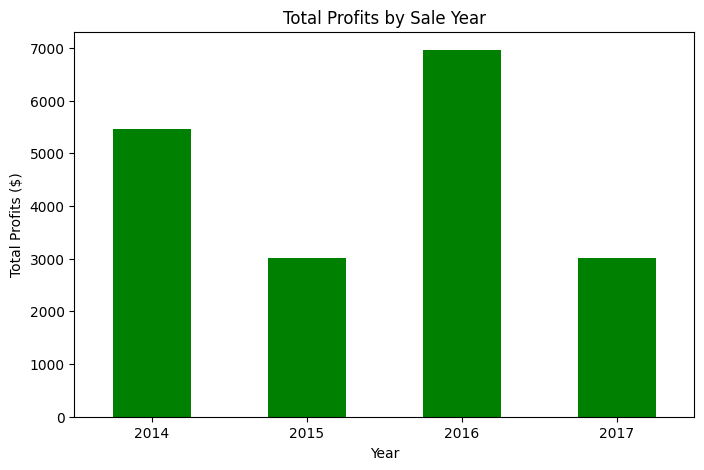

In [5]:
#Check sum of profits by sale year
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Year"] = df["Order Date"].dt.year

yearly_profits = df.groupby("Year")["Profit"].sum()

plt.figure(figsize=(8, 5))
yearly_profits.plot(kind='bar', color='green')
plt.title('Total Profits by Sale Year')
plt.xlabel('Year')
plt.ylabel('Total Profits ($)')
plt.xticks(rotation=0)
plt.show()

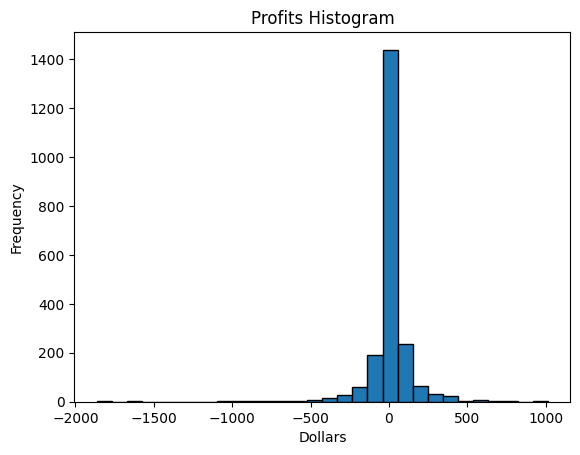

In [6]:
#Plot Profits histograms
plt.hist(df['Profit'],bins=30, edgecolor='black')
plt.title('Profits Histogram')
plt.xlabel('Dollars')
plt.ylabel('Frequency')
plt.show()

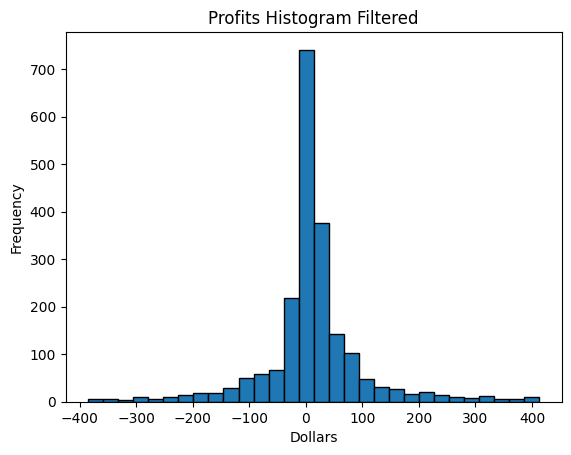

In [7]:
#Redo profits histogram with cutoff to eliminate outliers

#Cutoff at 2 standard devs
cutoff = 3
Lbound = df['Profit'].mean() - cutoff*df['Profit'].std()
Ubound = df['Profit'].mean() + cutoff*df['Profit'].std()

Profits_Filtered = df['Profit'][(df['Profit'] > Lbound) & (df['Profit'] < Ubound)]

plt.hist(Profits_Filtered,bins=30, edgecolor='black')
plt.title('Profits Histogram Filtered')
plt.xlabel('Dollars')
plt.ylabel('Frequency')
plt.show()

In [8]:
#Test if this is anything close to a Normal Distribution with a Shapiro-Wilk test
stat, p_value = stats.shapiro(Profits_Filtered)

print('P-value is: ' + str(round(p_value,5)))
if p_value > 0.05:
    print('There is insufficient evidence this data does not follow a normal distribution.')
else:
    print('The data does not conform to a normal distribution.')

P-value is: 0.0
The data does not conform to a normal distribution.


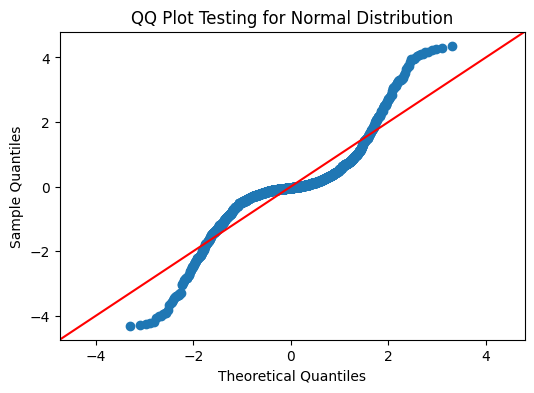

In [9]:
#Perform QQ tests for other potential distributions with high kurtosis and heavy tails

#Verify shapiro-wilk result
fig, ax = plt.subplots(figsize=(6,4))
sm.qqplot(Profits_Filtered,stats.norm, line='45', fit=True, ax=ax)
ax.set_title('QQ Plot Testing for Normal Distribution')
plt.show()

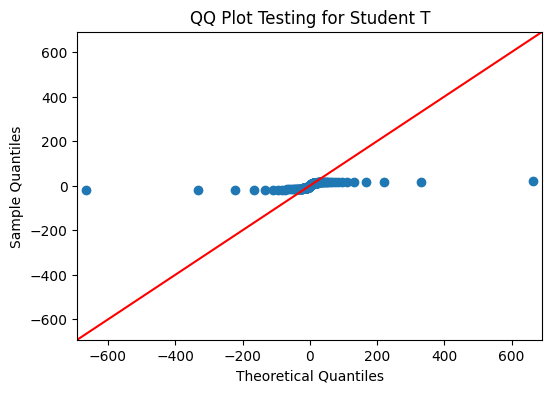

In [10]:
#Student T distribution
fig, ax = plt.subplots(figsize=(6,4))
sm.qqplot(Profits_Filtered,stats.t, line='45', fit=True, ax=ax)
ax.set_title('QQ Plot Testing for Student T')
plt.show()

## Sales Trends

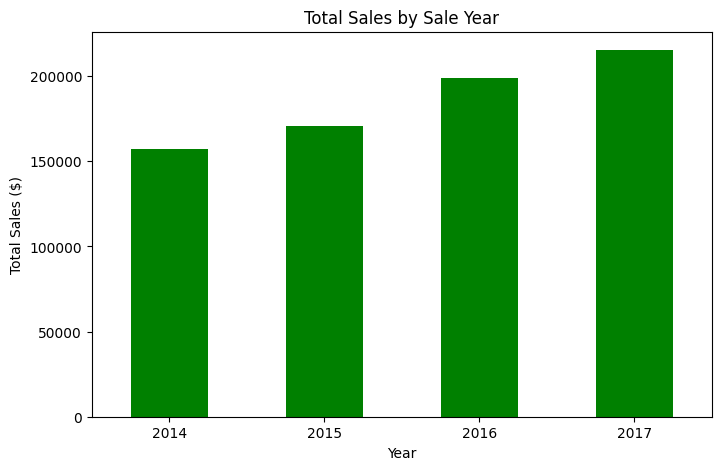

In [11]:
#Check sum of sales by year
yearly_sales = df.groupby("Year")["Sales"].sum()

plt.figure(figsize=(8, 5))
yearly_sales.plot(kind='bar', color='green')
plt.title('Total Sales by Sale Year')
plt.xlabel('Year')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=0)
plt.show()

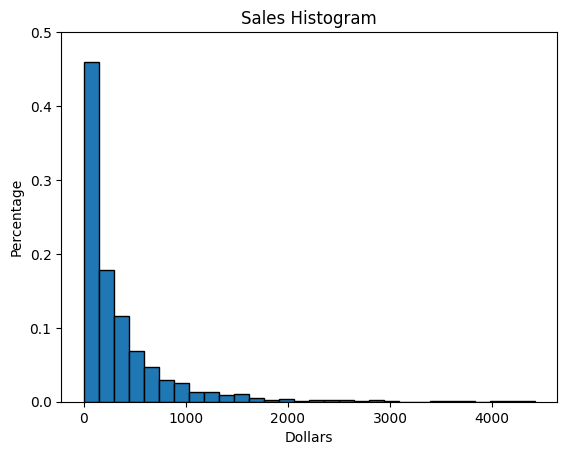

In [12]:
#Check distribution of sales with histogram
plt.hist(df['Sales'],bins=30, edgecolor='black',weights=np.ones(len(df['Sales']))/len(df['Sales']))
plt.title('Sales Histogram')
plt.ylim(0, 0.5)
plt.xlabel('Dollars')
plt.ylabel('Percentage')
plt.show()

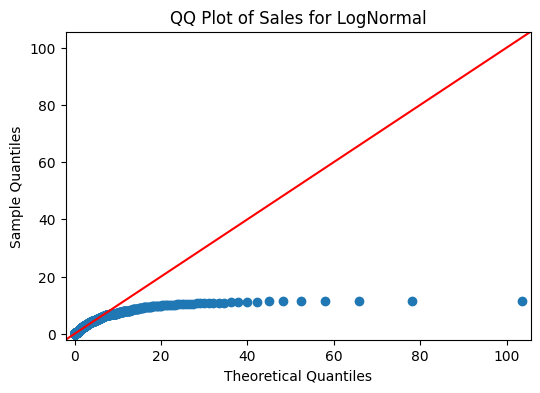

In [13]:
#Quick check if Sales follow a log-normal distribution
Sales_Filtered = df['Sales'][df['Sales'] < 3*df['Sales'].std()]

fig,ax=plt.subplots(figsize = (6,4))
sm.qqplot(Sales_Filtered,stats.lognorm,line='45',fit=True, ax=ax)
ax.set_title('QQ Plot of Sales for LogNormal')
plt.show()

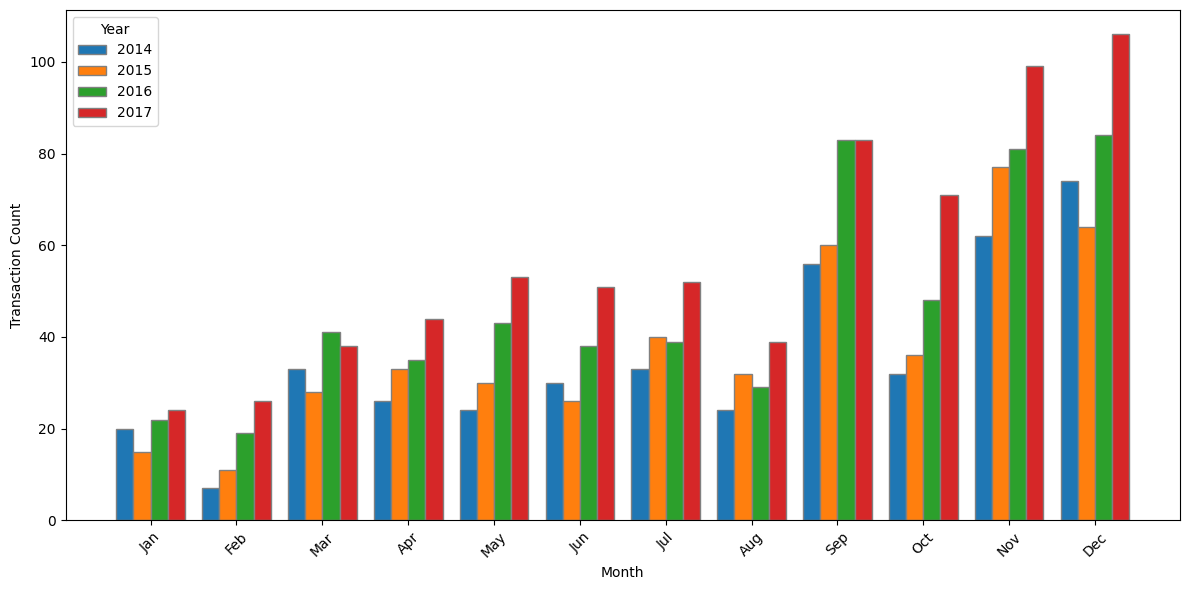

In [14]:
#Determine transactions by month and year

#Use format code %b to convert datetime to three-letter month abbreviation
df['Month Formatted'] = df['Order Date'].dt.strftime('%b')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_sales = df.groupby(['Year', 'Month Formatted']).size().reset_index(name='Transactions')

years = monthly_sales['Year'].unique()
monthly_sales['Month Formatted'] = pd.Categorical(monthly_sales['Month Formatted'], categories=months, ordered=True)

pivot_table = monthly_sales.pivot(index='Month Formatted', columns='Year', values='Transactions').reindex(months)

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2

r = np.arange(len(months))

for i, year in enumerate(pivot_table):
    ax.bar(r + i*bar_width,pivot_table[year],width=bar_width,edgecolor='grey',label=str(year))
    
ax.set_xlabel('Month')
ax.set_ylabel('Transaction Count')
ax.legend(title='Year')
ax.set_xticks(r + bar_width * (len(pivot_table.columns) - 1) / 2)
ax.set_xticklabels(months)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Categorical Trends

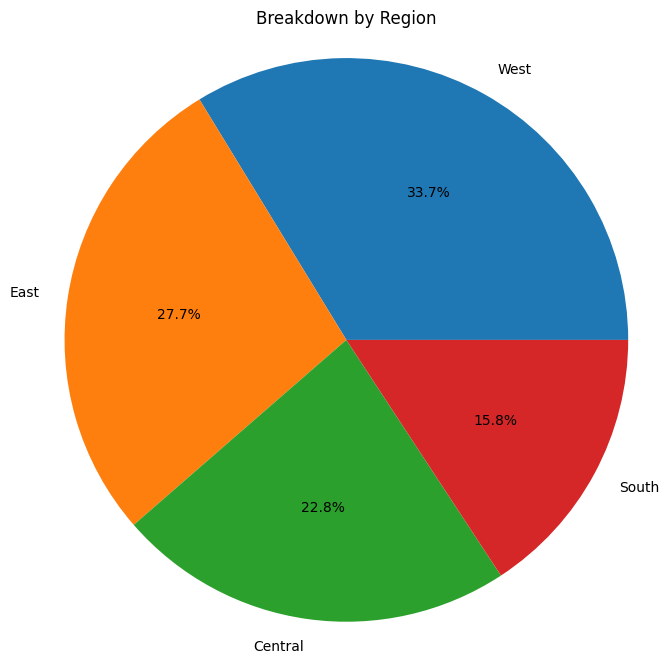

In [15]:
#Check breakdown by region, removing duplicate order IDs to avoid double-counting those orders
df_no_dupes = df.drop_duplicates(subset=['Order ID'])
Region_counts = df_no_dupes['Region'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(Region_counts,labels=Region_counts.index,autopct='%1.1f%%')
plt.title('Breakdown by Region')
plt.axis('equal')
plt.show()

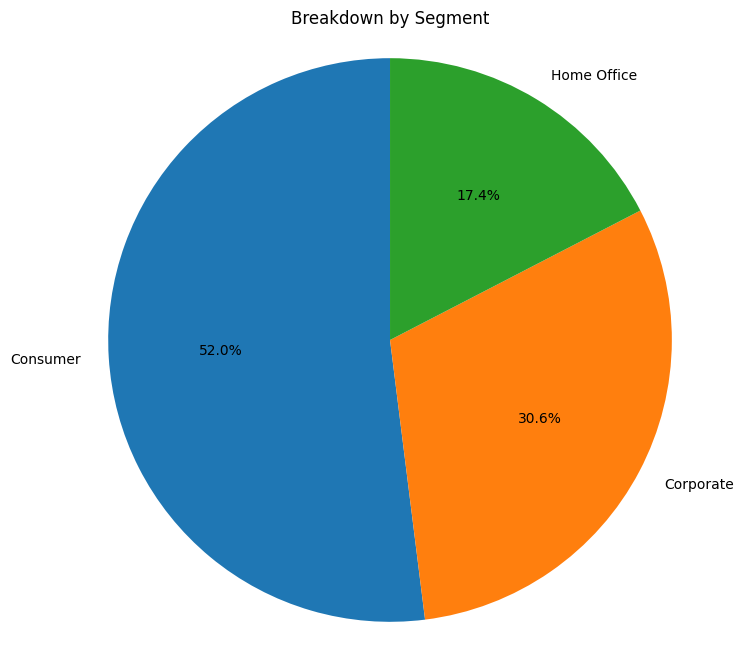

In [16]:
#Check breakdown by product segment
Segments = df_no_dupes['Segment'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(Segments,labels=Segments.index,autopct='%1.1f%%',startangle=90)
plt.title('Breakdown by Segment')
plt.axis('equal')
plt.show()

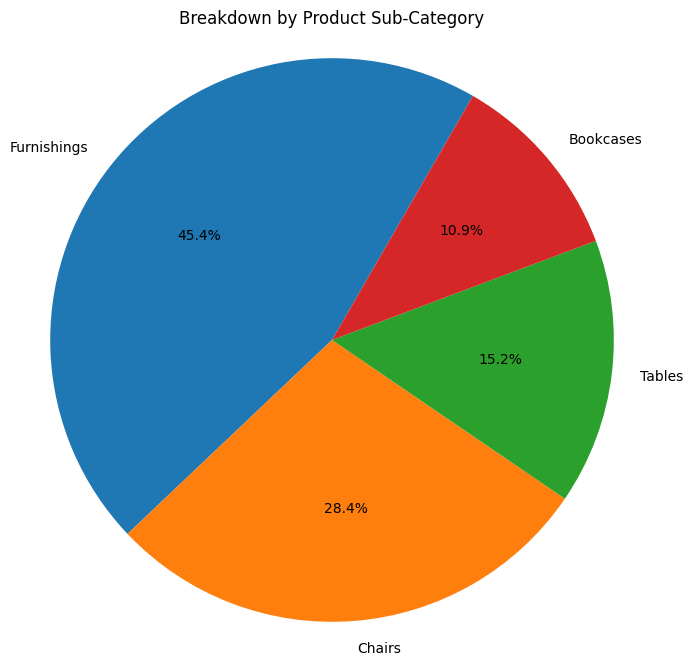

In [17]:
#Check breakdown by product sub-category

Sub_categories = df_no_dupes['Sub-Category'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(Sub_categories,labels=Sub_categories.index,autopct='%1.1f%%',startangle=60)
plt.title('Breakdown by Product Sub-Category')
plt.axis('equal')
plt.show()

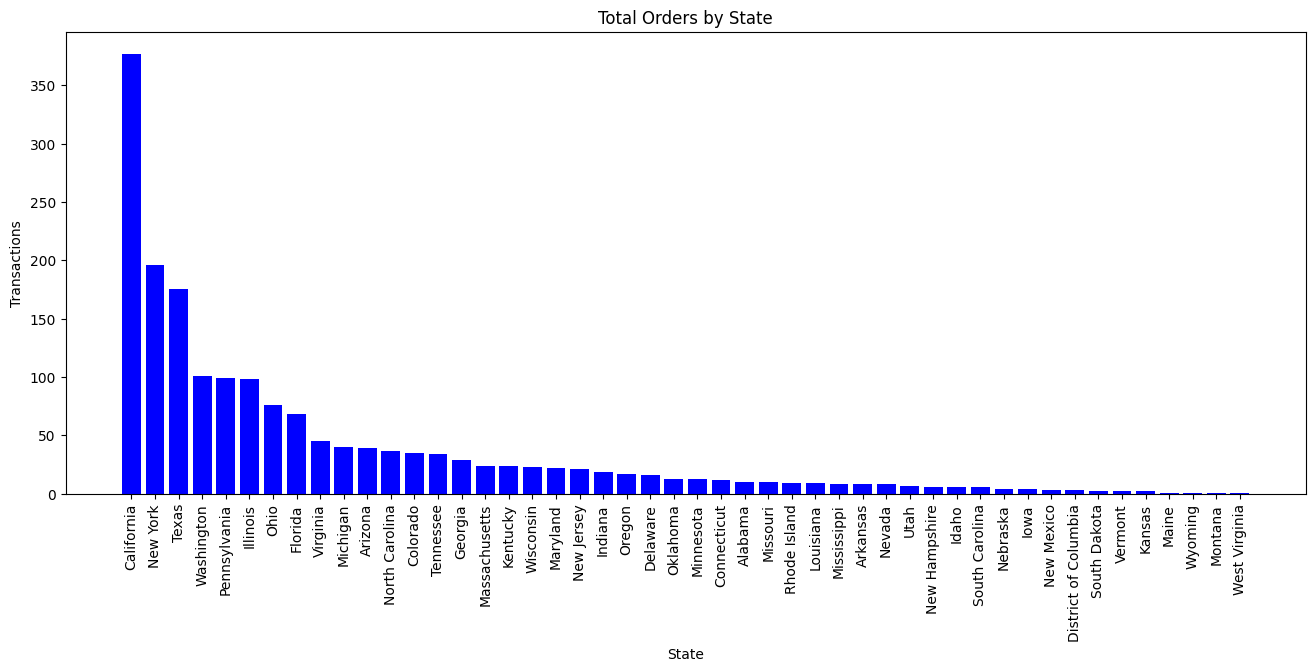

In [18]:
#Create bar graph of orders by state

States = df_no_dupes["State"].value_counts()

plt.figure(figsize=(16,6))
plt.bar(States.index,States.values,color='blue')
plt.title("Total Orders by State")
plt.xlabel("State")
plt.ylabel("Transactions")
plt.xticks(rotation=90)
plt.show()

# Further Profit Trend Analysis

## Hypothesis Testing

count    2121.000000
mean        3.878353
std        34.452956
min      -210.000000
25%        -7.142857
50%        11.111111
75%        27.500000
max        50.000000
Name: Profit Margin, dtype: float64


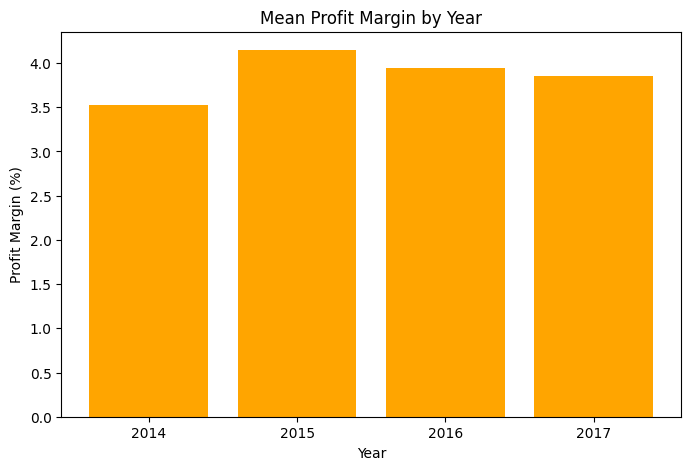

In [19]:
#Create additional features
df['Profit Margin'] = df['Profit']/df['Sales']*100

print(df['Profit Margin'].describe())

df["Unit Price"] = df["Sales"]/(df["Quantity"]*(1-df["Discount"]))

yearly_profit_margin = df.groupby('Year')['Profit Margin'].mean()

plt.figure(figsize=(8, 5))
plt.bar(yearly_profit_margin.index, yearly_profit_margin.values, color='orange')
plt.title('Mean Profit Margin by Year')
plt.xlabel('Year')
plt.ylabel('Profit Margin (%)')
plt.xticks(yearly_profit_margin.index.astype(int))
plt.show()

Mean discount in 2014 is: 0.182
Mean discount in 2015 is: 0.169
Mean discount in 2016 is: 0.177
Mean discount in 2017 is: 0.17


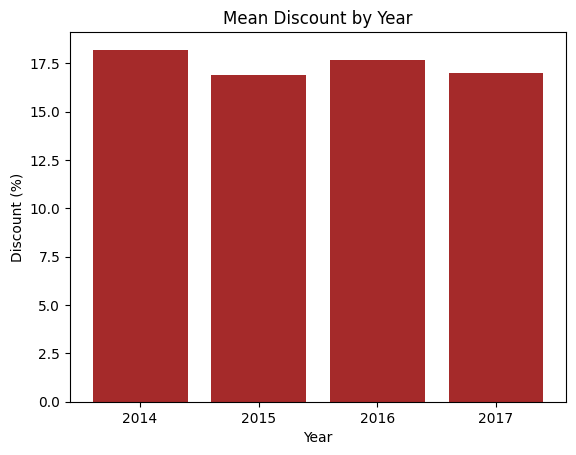

In [20]:
#Hypothesis: frivolous discounts are responsible for lower profits in 2015 and 2017. Let's compare the mean discounts each year and see how they differ.

yearly_discounts = df.groupby("Year")["Discount"].mean()
plt.bar(yearly_discounts.index, 100*yearly_discounts.values, color='brown')
plt.xticks(yearly_discounts.index.astype(int))
plt.xlabel("Year")
plt.ylabel("Discount (%)")
plt.title("Mean Discount by Year")

i = 2014

for value in yearly_discounts:
    print('Mean discount in ' + str(i) + ' is: ' + str(round(value,3)))
    i += 1

plt.show()

The slope of the linear regression line is: -168.47
The Pearson correlation coefficient is: -0.89


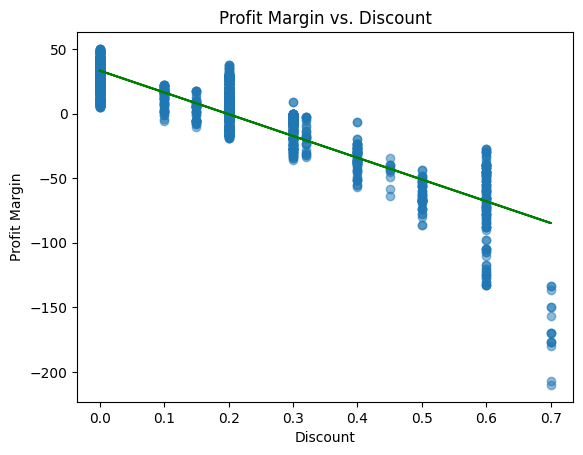

In [21]:
#Perform linear regression (should be very negative slope)
slope, intercept = np.polyfit(df['Discount'],df['Profit Margin'],1)
predicted_profit = np.polyval([slope, intercept],df['Discount'])

print("The slope of the linear regression line is: " + str(round(slope,2)))

#Check Pearson correlation coefficient (Less than -0.5 is a strong negative correlation)
corr_coef = np.corrcoef(df['Discount'],df['Profit Margin'])[0,1]
print('The Pearson correlation coefficient is: ' + str(round(corr_coef,2)))

#Plot scatter against regression line
plt.scatter(df['Discount'],df['Profit Margin'],alpha=.5)
plt.plot(df['Discount'],predicted_profit,color='green')
plt.xlabel('Discount')
plt.ylabel('Profit Margin')
plt.title('Profit Margin vs. Discount')
plt.show()

Mean sales value in 2014 is: 373.38
Mean sales value in 2015 is: 377.253
Mean sales value in 2016 is: 353.917
Mean sales value in 2017 is: 313.976


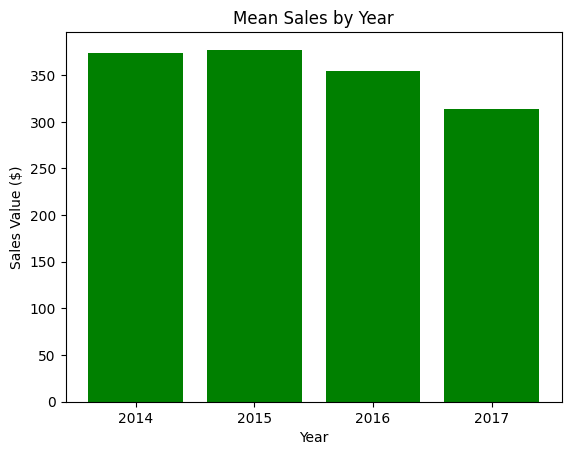

In [22]:
#Again no dice, there is no explanation above for why profits fluxuate by year as much as they do.
#Hypothesis: the mean sales values are lower in years with lower profits

yearly_mean_sales = df.groupby('Year')['Sales'].mean()

i = 2014

for value in yearly_mean_sales:
    print('Mean sales value in ' + str(i) + ' is: ' + str(round(value,3)))
    i += 1

plt.bar(yearly_mean_sales.index,yearly_mean_sales.values,color='green')
plt.xticks(yearly_mean_sales.index.astype(int))
plt.xlabel("Year")
plt.ylabel("Sales Value ($)")
plt.title("Mean Sales by Year")

plt.show()

Overall transaction count in 2014 is: 421 transactions.
Overall transaction count in 2015 is: 452 transactions.
Overall transaction count in 2016 is: 562 transactions.
Overall transaction count in 2017 is: 686 transactions.


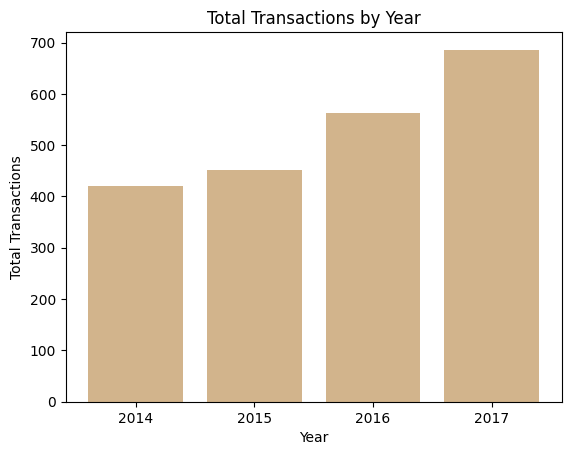

In [23]:
#Mean sales values do not appear to explain profit trends either
#Hypothesis: years with higher profits simply have more total transactions

Transactions_Yearly_Count = df["Year"].value_counts().sort_index()

i = 2014

for value in Transactions_Yearly_Count:
    print('Overall transaction count in ' + str(i) + ' is: ' + str(round(value,3)) + ' transactions.')
    i += 1

plt.bar(Transactions_Yearly_Count.index, Transactions_Yearly_Count.values,color='tan')
plt.xticks(yearly_discounts.index.astype(int))
plt.xlabel("Year")
plt.ylabel("Total Transactions")
plt.title("Total Transactions by Year")
plt.show()

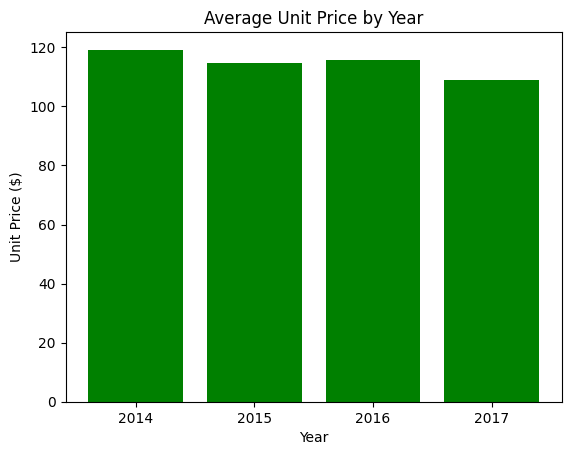

In [24]:
#Hypothesis: goods sold in lower-profit years have lower individual prices
Price_by_year = df.groupby("Year")["Unit Price"].mean()
plt.bar(Price_by_year.index, Price_by_year.values,color='green')  
plt.xticks(yearly_discounts.index.astype(int))
plt.xlabel("Year")
plt.ylabel("Unit Price ($)")
plt.title("Average Unit Price by Year")
plt.show()

## Regional Profit Trends

    Region  Profit Margin
0  Central     -18.583641
1     East       9.238888
2    South      14.166165
3     West       9.772249


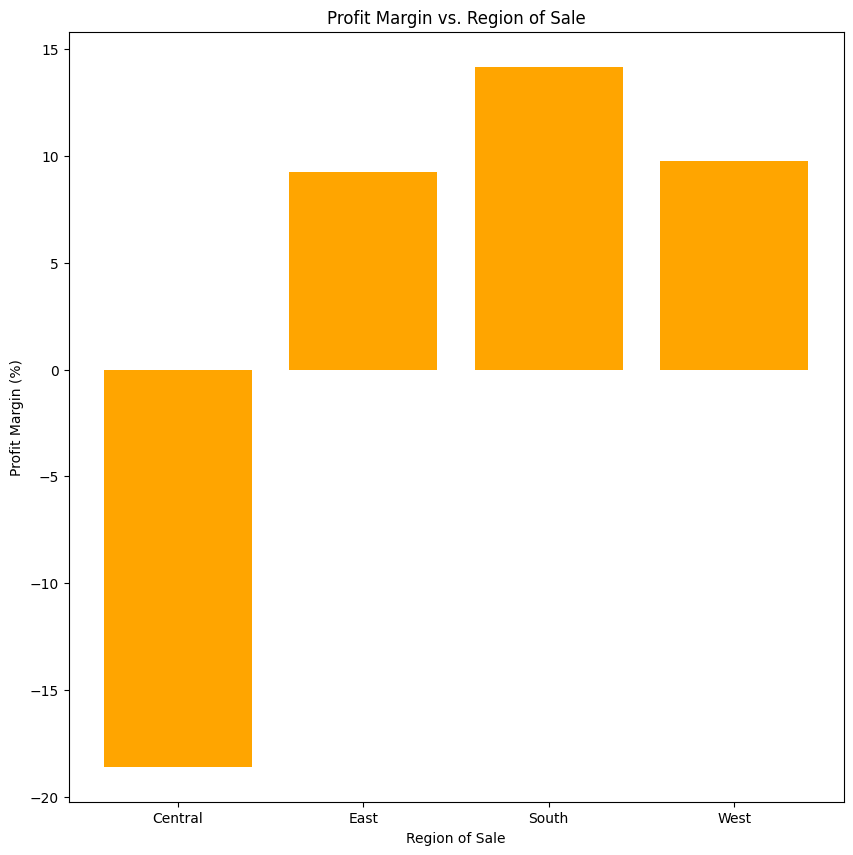

In [25]:
#There are no clear suspects, but we know that discounts have a strong negative impact on profits, so let's take a closer look
#Let's break it down by region
df_by_region = df.groupby('Region')['Profit Margin'].mean().reset_index()

print(df_by_region.head())

#Plot profits by region
plt.figure(figsize=(10,10))
plt.bar(df_by_region['Region'],df_by_region['Profit Margin'],color='orange')
plt.xlabel("Region of Sale")
plt.ylabel("Profit Margin (%)")
plt.title("Profit Margin vs. Region of Sale")
plt.show()

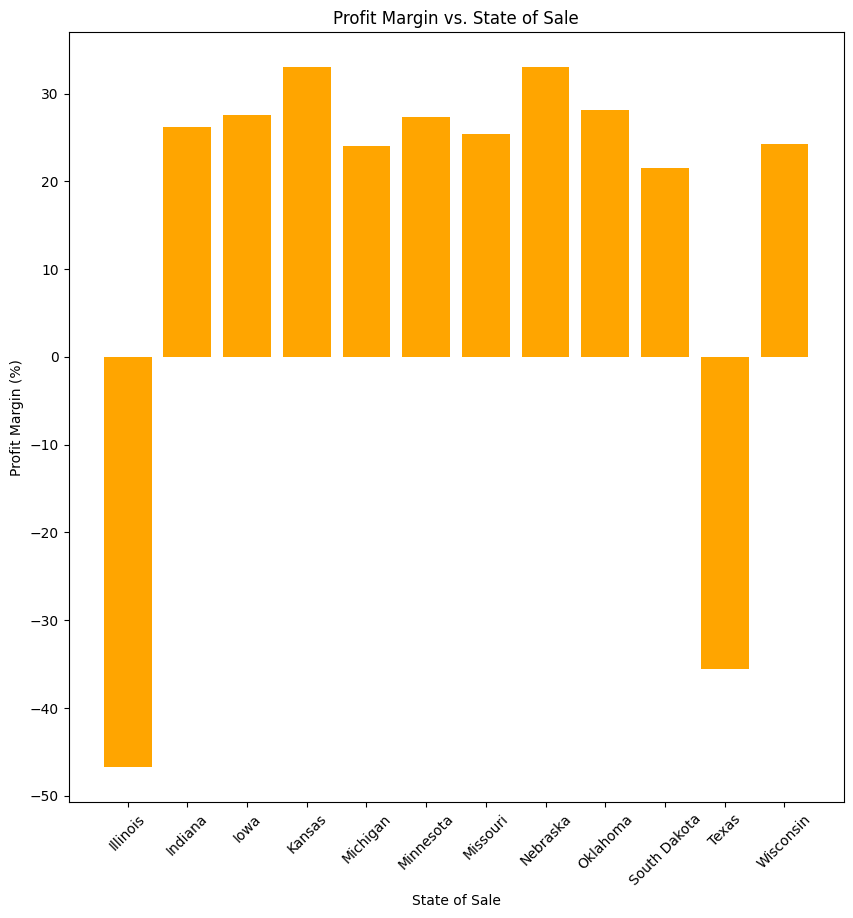

In [26]:
#It looks like all regions are profitable except for Central, so lets look at the individual central states
central_df = df.loc[df['Region']=='Central']

#Group profits in new central-only df by state and reindex
central_df_profits_by_state = central_df.groupby('State')['Profit Margin'].mean().reset_index()

#Plot results
plt.figure(figsize=(10,10))
plt.bar(central_df_profits_by_state['State'],central_df_profits_by_state['Profit Margin'],color='orange')
plt.xticks(rotation=45)
plt.xlabel("State of Sale")
plt.ylabel("Profit Margin (%)")
plt.title("Profit Margin vs. State of Sale")
plt.show()

State
Texas        175
Illinois      98
Michigan      40
Wisconsin     23
Indiana       19
Name: count, dtype: int64


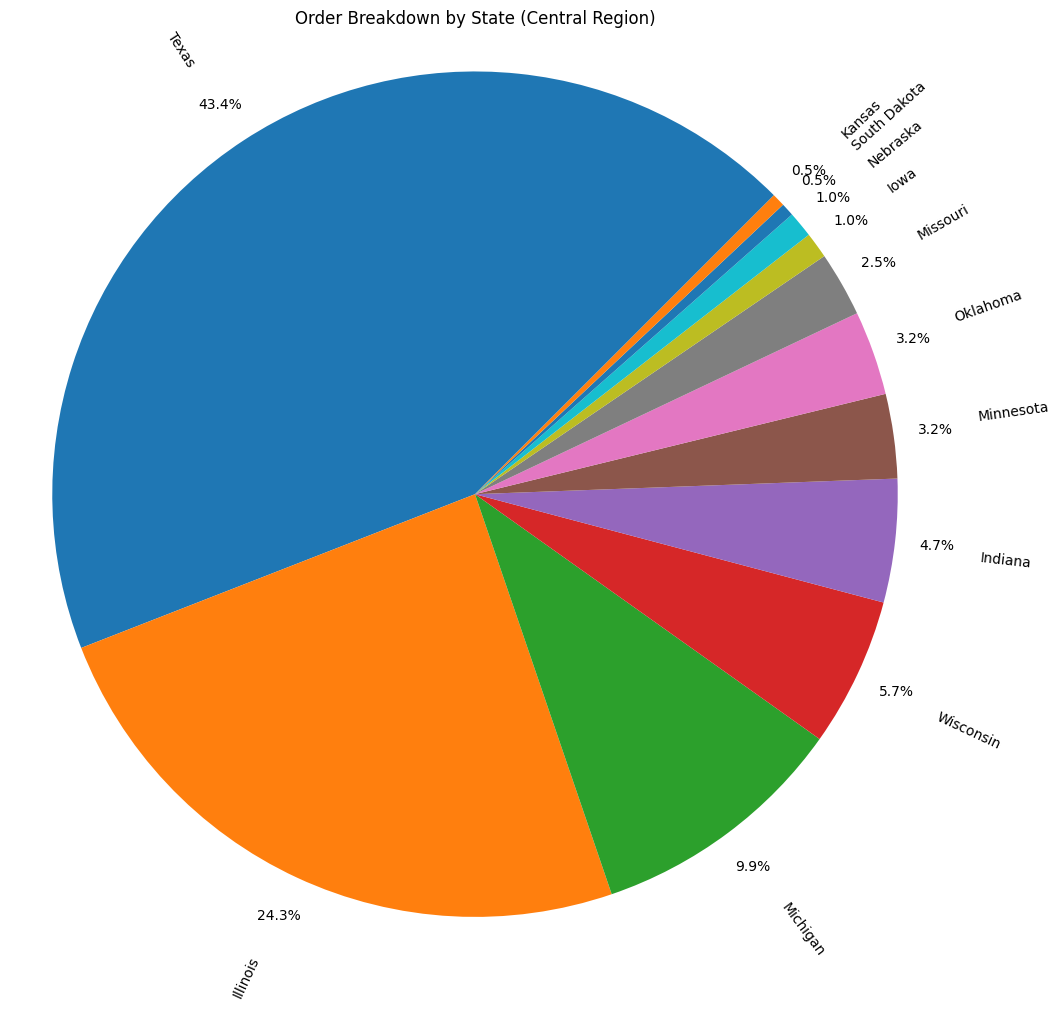

In [27]:
#Within the Central region, all states except Illinois and Texas are profitable
#Let's check what percent of orders they contribute to the region with a pie chart; together I would expect they comprise a majority of orders in the region

central_df_unique = central_df.drop_duplicates(subset=['Order ID'])
state_counts = central_df_unique['State'].value_counts()

#Print out five most high-order states
print(state_counts.head())

#Plot results
plt.figure(figsize=(12,12))
plt.pie(state_counts, labels=state_counts.index,autopct='%1.1f%%',startangle=45,labeldistance=1.2,pctdistance=1.1,rotatelabels=True)
plt.axis('equal')
plt.title("Order Breakdown by State (Central Region)")
plt.show()

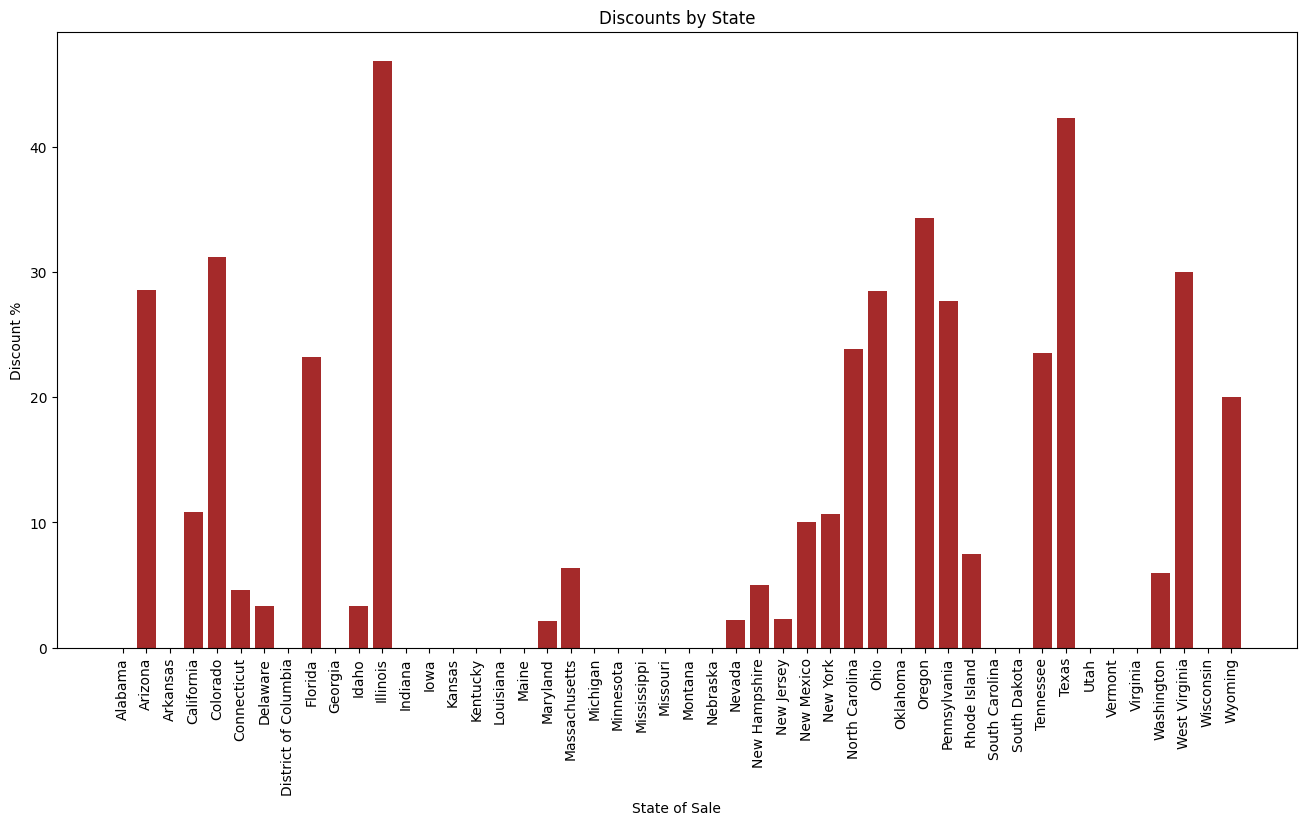

In [28]:
#Compare average discounts across all states

df_discount_by_state = df.groupby('State')['Discount'].mean().reset_index()
df_discount_by_state['Discount'] = df_discount_by_state['Discount']*100

plt.figure(figsize=(16,8))
plt.bar(df_discount_by_state['State'], df_discount_by_state['Discount'],color = 'brown')
plt.xticks(rotation=90)
plt.title('Discounts by State')
plt.xlabel('State of Sale')
plt.ylabel('Discount %')
plt.show()

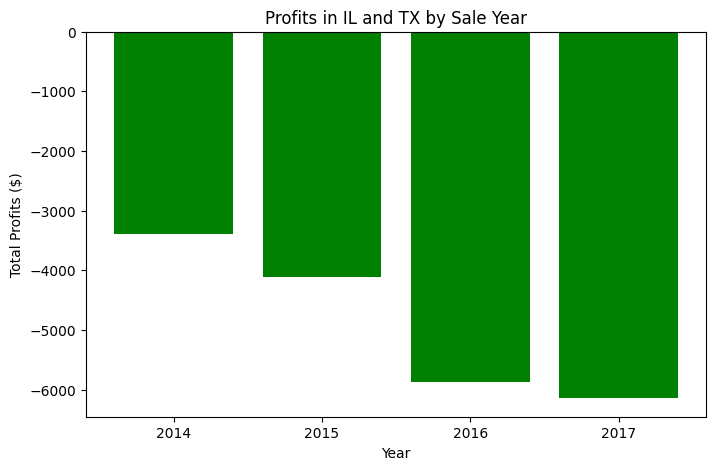

In [29]:
#Determine total profits for Illinois and Texas across all years

mask = (df['State'] != 'Illinois') & (df['State'] != 'Texas')

df_only_ILTX = df.drop(df[mask].index)

yearly_profits_only_ILTX = df_only_ILTX.groupby("Year")["Profit"].sum()

plt.figure(figsize=(8, 5))
plt.bar(yearly_profits_only_ILTX.index,yearly_profits_only_ILTX.values,color='green')
plt.title('Profits in IL and TX by Sale Year')
plt.xlabel('Year')
plt.ylabel('Total Profits ($)')
plt.xticks(yearly_profits_only_ILTX.index.astype(int))
plt.show()

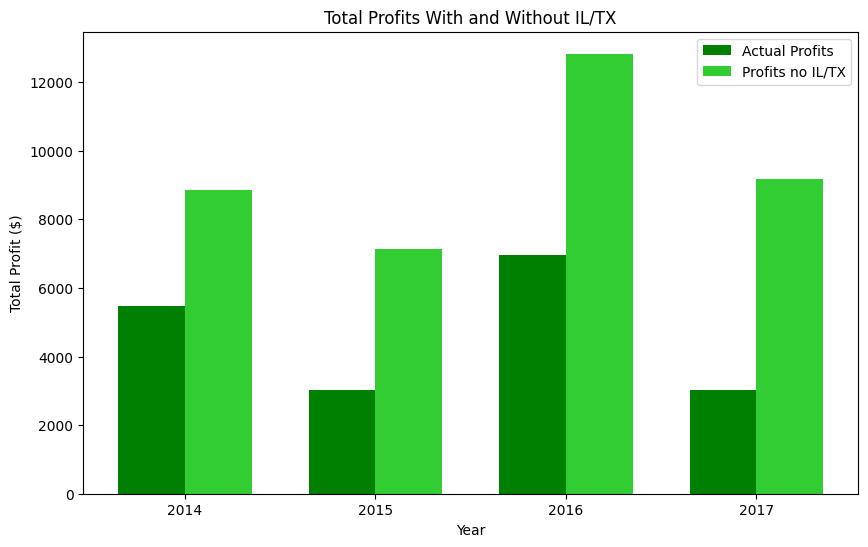

In [30]:
#Plot actual profits against what they would be if no sales were made in IL/TX
mask = (df['State'] == 'Illinois') | (df['State'] == 'Texas')

df_no_ILTX = df.drop(df[mask].index)

yearly_profits_no_ILTX = df_no_ILTX.groupby("Year")["Profit"].sum()

bar_width = 0.35
index = np.arange(4)

years = ['2014','2015','2016','2017']

fig, ax = plt.subplots(figsize=(10,6))
bar1 = ax.bar(index-bar_width/2,yearly_profits.values,bar_width, label='Actual Profits',color='green')
bar1 = ax.bar(index+bar_width/2,yearly_profits_no_ILTX.values,bar_width, label='Profits no IL/TX',color='limegreen')
ax.legend()
ax.set_xticks(index)
ax.set_xticklabels(years)
ax.set_xlabel('Year')
ax.set_ylabel('Total Profit ($)')
ax.set_title('Total Profits With and Without IL/TX')
plt.show()

# ML Modeling

## Feature Engineering

In [31]:
#Cutoff at 3 standard devs to remove outliers
cutoff = 3
Lbound = df['Profit'].mean() - cutoff*df['Profit'].std()
Ubound = df['Profit'].mean() + cutoff*df['Profit'].std()

df = df[(df['Profit'] > Lbound) & (df['Profit'] < Ubound)]

In [32]:
#Create additional datetime features for training

df['Month'] = df['Order Date'].dt.month
df['Day'] = df['Order Date'].dt.day
df['Weekday'] = df['Order Date'].dt.weekday
df['Quarter'] = df['Order Date'].dt.quarter

df = df.sort_values(by='Order Date') 
df_original = df 

In [33]:
#Create Lag and Rolling features
df['Profit Lag'] = df['Profit'].shift(364)

df['Profit Rolling Mean'] = df['Profit'].rolling(window=364).mean()
df['Profit Rolling Sum'] = df['Profit'].rolling(window=364).sum()
df['Profit Rolling STD'] = df['Profit'].rolling(window=364).std()

In [34]:
#Encode categorical variables and add to Dataframe
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[['Region','Sub-Category','State']])
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out())

df = pd.concat([df, encoded_df],axis=1)
df = df.dropna()

In [35]:
#Compile features list for model training
features = df[['Year','Month','Quarter','Day','Weekday','Profit Lag','Profit Rolling Mean','Profit Rolling STD','Profit Rolling Sum']+ list(encoded_df.columns)] 

#Split Training and Validation data 
train_data = df.loc[df['Year']<2017]
val_data = df.loc[df['Year']==2017]

#Create training and validation sets for features and targets
x_train = train_data[features.columns]
y_train = train_data['Profit'] 
x_val = val_data[features.columns]
y_val = val_data['Profit']

## Random Forest Model

In [36]:
#Set up Random Forest model and fit to training data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

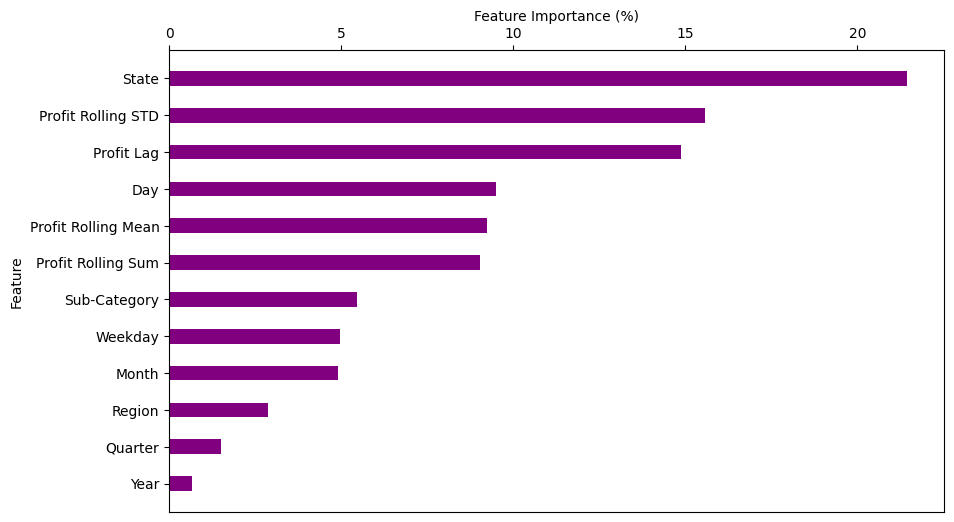

In [37]:
#Determine feature importances
features = x_train.columns
feature_importances = model.feature_importances_

#Create new importance dataframe
importance_df = pd.DataFrame({'Feature':features,'Importance':feature_importances})

#Call function to aggregate categoricals
importance_df = Aggregate_Categoricals(importance_df,"Region")
importance_df = Aggregate_Categoricals(importance_df,"State")
importance_df = Aggregate_Categoricals(importance_df,"Sub-Category")

plt.figure(figsize=(10, 6))
plt.barh(importance_df.sort_values('Importance')['Feature'],importance_df.sort_values('Importance')['Importance']*100,height=0.4,color='purple')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature')

plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

plt.show()

In [38]:
#Make predictions for 2017 and compare to values in validation set
y_pred = model.predict(x_val)
mse = mean_squared_error(y_val, y_pred)
print(f'Mean Squared Error: {round(mse,2)}')

rmse = round(math.sqrt(mse),2)
profit_range = df['Profit'].max() - df['Profit'].min()

rel_RMSE = str(round(100*rmse/profit_range,2))

print("RMSE: " + str(rmse))
print("Relative RMSE: " + rel_RMSE + '%')


Mean Squared Error: 7894.44
RMSE: 88.85
Relative RMSE: 11.14%


## Visualized Results

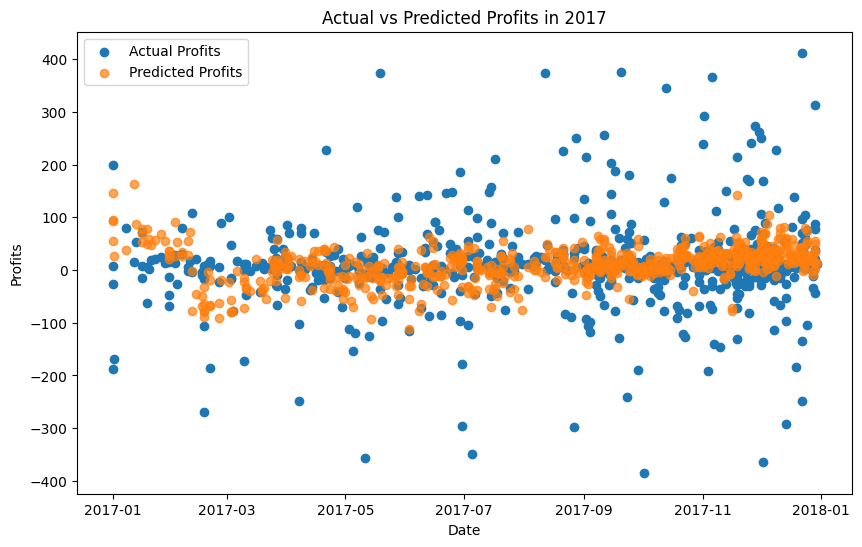

In [39]:
val_data.loc[:,'Predicted Profits'] = y_pred

#Plot results as scatter
plt.figure(figsize=(10, 6))
plt.scatter(val_data['Order Date'], val_data['Profit'], label='Actual Profits')
plt.scatter(val_data['Order Date'], val_data['Predicted Profits'], label='Predicted Profits', alpha = 0.7)
plt.xlabel('Date')
plt.ylabel('Profits')
plt.title('Actual vs Predicted Profits in 2017')
plt.legend()
plt.show()

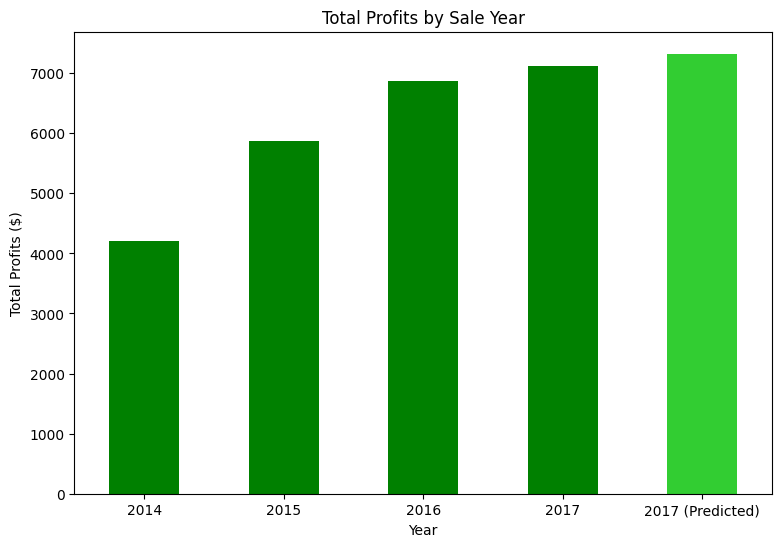

In [40]:
#Add predicted 2017 profit sum to previously defined slice
yearly_profits_no_outliers = df_original.groupby('Year')['Profit'].sum()
yearly_profits_no_outliers['2017 (Predicted)'] = val_data['Predicted Profits'].sum()

colors = ['green','green','green','green','limegreen']

plt.figure(figsize=(9, 6))
yearly_profits_no_outliers.plot(kind='bar', color=colors)
plt.title('Total Profits by Sale Year')
plt.xlabel('Year')
plt.ylabel('Total Profits ($)')
plt.xticks(rotation=0)
plt.show()